In [1]:
'''Load libs'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.interpolate import CubicSpline

plt.style.use('bmh')
np.random.seed(42)

# Generate data

In [2]:
def plot_signal(signal, l, c='k'):
    plt.plot(signal, c, label=l, linewidth=1)
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.ylim(-1.5,1.5)
    plt.legend(loc='upper right')

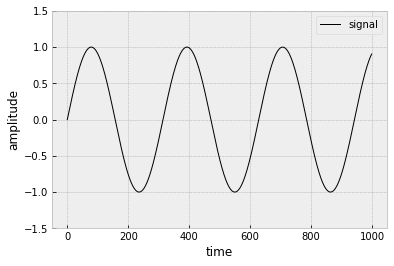

In [3]:
n_time = 1000
t = np.arange(0, n_time)

signal = np.sin(t * 0.02)
plot_signal(signal, 'signal')

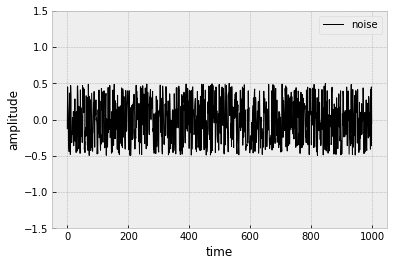

In [4]:
noise = np.random.uniform(-0.5,0.5,n_time)
plot_signal(noise, 'noise')

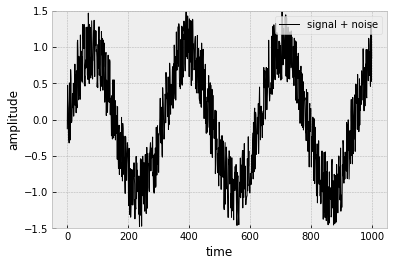

In [5]:
signal_add_noise = signal + noise
plot_signal(signal_add_noise, 'signal + noise')

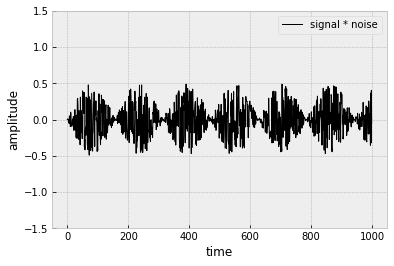

In [6]:
signal_mul_noise = signal * noise
plot_signal(signal_mul_noise, 'signal * noise')

# Empirical Mode Decomposition  
The EMD method is a necessary step to reduce any given data into a collection of intrinsic mode functions (IMF) to which the Hilbert spectral analysis can be applied.

1. Identify all the local extrema in the test data.
2. Connect all the local maxima by a cubic spline line as the upper envelope.
3. Repeat the procedure for the local minima to produce the lower envelope.

**max_imf** - number of Intrinsic mode functions (IMF)  
**min_std** - std of final function. Stoping condition

In [7]:
def max_min_envelopes(signal):
    d = np.diff(signal)
    N = len(signal)
    t = np.arange(0,N)

    maxmin = []

    # Find local max/min points
    for i in range(N-2):
        if d[i] == 0:
            if np.sign(d[i-1]) != np.sign(d[i+1]):
                maxmin += [i]

        elif np.sign(d[i]) != np.sign(d[i+1]):
            maxmin += [i+1]

    if len(maxmin) <= 2:
        return -1, -1

    # Divide maxmin into maxes and mins
    if maxmin[0] > maxmin[1]:
        maxes = maxmin[0::2]
        mins = maxmin[1::2]
    else:
        maxes = maxmin[1::2]
        mins = maxmin[0::2]

    # Fix endpoints
    maxes.insert(0,0)
    maxes.append(N-1)
    mins.insert(0,0)
    mins.append(N-1)

    # Spline interpolate for max and min envelopes, form imf
    maxenv_cs = CubicSpline(maxes, signal[maxes])
    minenv_cs = CubicSpline(mins, signal[mins])

    maxenv = maxenv_cs(t)
    minenv = minenv_cs(t)

    return maxenv, minenv

In [8]:
def get_imfs(signal, max_imf = 10, min_std = 0.1):
    IMFs = []

    local_signal = signal.copy()

    for n in range(max_imf):
        print('\tN',n)
        imf = local_signal
        std = 1

        while std > min_std:
            maxenv, minenv = max_min_envelopes(imf)

            # If can't find min/max points, exit
            if (type(maxenv) == int or type(minenv) == int):
                print('can\'t find min/max points')
                break

            # Mean of max and min enveloppes
            meanenv = (maxenv + minenv) / 2

            # Copy of the previous value of h before modifying it
            prev_imf = imf.copy()

            imf = imf - meanenv

            # Calculate standard deviation
            std = sum(((prev_imf - imf)**2) / (prev_imf**2 + 1e-9))

        IMFs += [imf]
        local_signal -= imf
    return IMFs

In [9]:
def plot_imfs(imfs):
    fig, ax = plt.subplots(len(imfs), 1, figsize=(12,8))
    for i in range(len(imfs)):
        ax[i].plot(imfs[i])
    fig.tight_layout()

In [10]:
imfs = get_imfs(signal_add_noise)

	N 0
	N 1
	N 2
	N 3
	N 4
	N 5
	N 6
	N 7
	N 8
	N 9


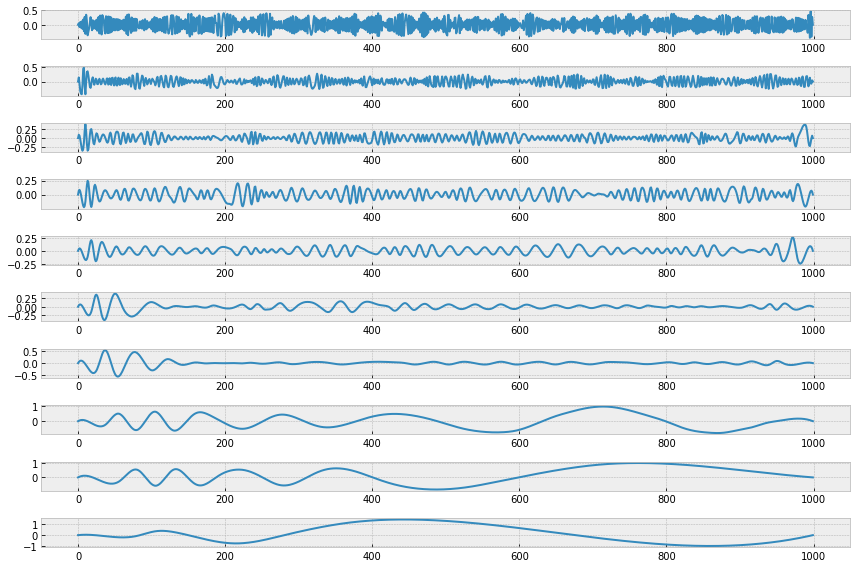

In [12]:
plot_imfs(imfs)

# 